In [1]:
from modules.sheet_process import CoverSheet
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pickle
from scipy.ndimage import interpolation

In [2]:
clf = pickle.load(open('SVCtrained.dms','rb'))
pca = pickle.load(open("PCAtrained.dms",'rb'))

In [335]:
def remove_spots(img,min_size=30):
    '''
    remove the spots in which the number of pixels are less than min_size
    @ param min_size int or None minimum size of the project
        if it is defined as none then only the object has the maximal number of pixels will be reserved
    '''
    digit_imgs = []
    img_copy = img.copy()
    nb_components, labels_mask,stats,_ = cv.connectedComponentsWithStats(img, connectivity=8)
    # iterate over each label but skip the background
    if min_size is not None:
        for label in range(1,nb_components):
            # check the number of the pixels of the object
            if stats[label,-1] < min_size:
                img_copy[labels_mask==label] = 0
    else:
        label_max = np.argmax(stats[1:,-1])+1
        img_copy = (labels_mask==label_max).astype(np.uint8)*255
    return img_copy

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
def deskew(image,rotate = True):
    c,v = moments(image)
    if rotate:
        alpha = v[0,1]/v[0,0]
    else:
        alpha = 0
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)
def resize_digit(img,output_size = 28,zero_padding=3):
    img = remove_spots(img,min_size=None)
    contours, _= cv.findContours(img,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    assert len(contours)==1, 'digit is broken'
    x,y,w,h = cv.boundingRect(contours[0])
    # extract the object
    img = img[y:y+h,x:x+w]
    h,w = img.shape
    ratio = h/w
    effective_size = output_size-zero_padding*2
    # resize the image and reserve the ratio of the object
    if ratio >1 :
        img = cv.resize(
            img,
            (int(np.round(effective_size/ratio)),effective_size))
        
    else:
        img = cv.resize(
            img,
            (effective_size,int(np.round(effective_size*ratio))))
    # zero padding
    output_img = np.zeros((output_size,output_size))
    left_upper = (output_size//2-img.shape[0]//2,output_size//2-img.shape[1]//2)
    output_img[left_upper[0]:left_upper[0]+img.shape[0],
               left_upper[1]:left_upper[1]+img.shape[1]] = img
    return output_img
def find_digits(img):
    outputs = []
    x_list = []
    contours, _= cv.findContours(img,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x,y,w,h = cv.boundingRect(contour)
        outputs.append(img[y:y+h,x:x+w].copy())
        x_list.append(x)
    zipped_outputs = zip(outputs,x_list)
    sorted_zip=sorted(zipped_outputs,key= lambda t: t[1])
    outputs = [item[0] for item in sorted_zip]
    return outputs

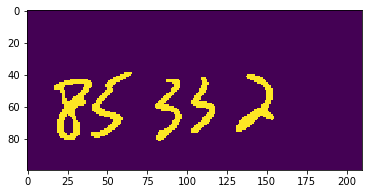

In [380]:
coversheet = CoverSheet((580,680,1290,1500),'scan/scan-33.jpg')
img = coversheet.digits_string.img
structure_kernel = cv.getStructuringElement(cv.MORPH_CROSS,(1,1))
img = cv.erode(img,structure_kernel)
img = remove_spots(img)
plt.imshow(img)

  1th digit is :[8]
  2th digit is :[5]
  3th digit is :[3]
  4th digit is :[5]
  5th digit is :[2]


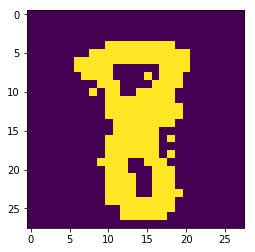

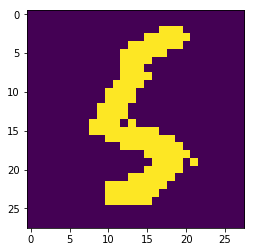

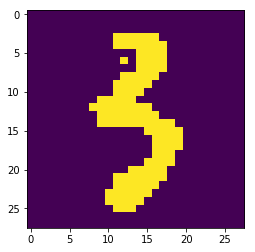

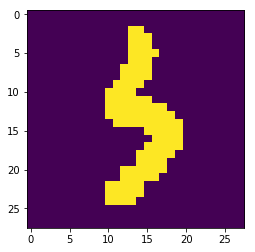

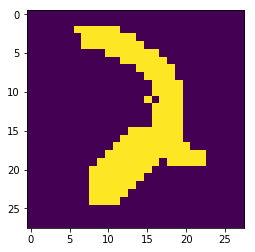

In [381]:
digit_imgs =  find_digits(img)
len(digit_imgs)
for idx,digit_img in enumerate(digit_imgs):
    # digit_img = remove_spots(digit_img,min_size=None)
    digit_img = resize_digit(digit_img)
    digit_img = deskew(digit_img,rotate=True)>10
    plt.figure()
    plt.imshow(digit_img)
    print('{:3d}th digit is :{}'.format(idx+1,clf.predict(pca.transform(digit_img.reshape(1,-1)))))

In [58]:
# digit = img[20:,110:150]
# digit = img[:,150:186]
# digit = img[20:,40:75]
digit = img[40:82,45:70]
# digit = img[50:85,98:110]
digit2= resize_digit(digit)
digit2 = deskew(digit2,rotate=False)>30
digit1 = resize_digit(digit)>0

0


Text(0.5, 1.0, '[5]')

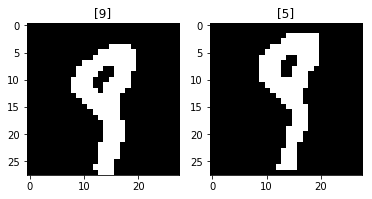

In [59]:
plt.subplot(1,2,1)
plt.imshow(digit2,cmap = 'gray')
plt.title(str(clf.predict(pca.transform(digit2.reshape(1,-1)))))
plt.subplot(1,2,2)
plt.imshow(digit1,cmap = 'gray')
plt.title(str(clf.predict(pca.transform(digit1.reshape(1,-1)))))

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [ ]:
mnist.data.shape

In [ ]:
idx = 69200
img = mnist.data[idx].reshape(28,28)>0
plt.imshow(img)
print('target:{},\t predicted:{} '.format(
    mnist.target[idx],
    clf.predict(pca.transform(img.reshape(1,-1)))))